In [ ]:
import pandas as pd
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [ ]:
def convert_bbox(xc, yc, w, h, img_width, img_height):
    x1 = int((xc - w / 2) * img_width)
    y1 = int((yc - h / 2) * img_height)
    x2 = int((xc + w / 2) * img_width)
    y2 = int((yc + h / 2) * img_height)
    return x1, y1, x2, y2

In [1]:
PATH2DATASET = 'train_data_minprirodi/images/'

In [10]:
DF_PATH = './train_data_minprirodi/annotation.csv'

### Bbox transformation and random train val split

In [10]:
df = pd.read_csv(DF_PATH)

In [152]:
x1s, y1s, x2s, y2s = [], [], [], []
for ind, row in df.iterrows():
    img = plt.imread(row['fname'])
    bbox = [float(el) for el in row['Bbox'].split(',')]
    xc, yc, w, h = bbox
    img_height, img_width, _ = img.shape
    x1, y1, x2, y2 = convert_bbox(xc, yc, w, h, img_width, img_height)
    x1s.append(x1)
    x2s.append(x2)
    y1s.append(y1)
    y2s.append(y2)

In [153]:
df['x1'] = x1s
df['x2'] = x2s
df['y1'] = y1s
df['y2'] = y2s

In [36]:
df['fname'] = df['Name'].apply(lambda x: PATH2DATASET+x)
df.head()

,Name,Bbox,Class,fname
0,1001958.jpg,"0.7075520833333333,0.5319444444444444,0.282812...",1,train_data_minprirodi/images/1001958.jpg
1,1001958.jpg,"0.09505208333333333,0.6305555555555555,0.19010...",0,train_data_minprirodi/images/1001958.jpg
2,1001958.jpg,"0.031510416666666666,0.7434027777777777,0.0630...",0,train_data_minprirodi/images/1001958.jpg
3,1002155.jpg,"0.8135416666666667,0.6976851851851852,0.371875...",0,train_data_minprirodi/images/1002155.jpg
4,1002155.jpg,"0.3221354166666667,0.7939814814814815,0.477604...",0,train_data_minprirodi/images/1002155.jpg


### Here we split all data into two random parts: 0.2 and 0.8.

In [122]:
name2split = {}
for el in df['Name'].unique():
    name2split[el] = 'train' if np.random.uniform() > 0.2 else 'val' 

In [124]:
df['split'] = df['Name'].apply(lambda x: name2split[x])

In [125]:
for group_name, gr in df.groupby('split'):
    print(group_name, len(gr), gr['Class'].value_counts().to_dict())

train 1612 {1: 981, 0: 631}
val 373 {1: 213, 0: 160}


In [154]:
df.to_csv("annotation_split.csv")

### CLIP Clustering

In [112]:
import torch
import open_clip
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import os

In [124]:
model_clip, _, preprocess_clip = open_clip.create_model_and_transforms('ViT-SO400M-14-SigLIP-384', pretrained='webli')
model_clip.eval()
model_clip.to('cuda')

CustomTextCLIP(
  (visual): TimmModel(
    (trunk): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1152, out_features=3456, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1152, out_features=1152, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featur

In [199]:
# Folder containing images
image_folder = 'train_data_minprirodi/images'
images = []
image_vectors = []

# Process images and extract vectors
for filename in tqdm(os.listdir(image_folder)):
    image_path = os.path.join(image_folder, filename)
    image = preprocess_clip(Image.open(image_path)).unsqueeze(0).to('cuda')
    with torch.no_grad():
        image_features = model_clip.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        image_vectors.append(image_features.cpu().numpy())
        images.append(filename)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1586/1586 [02:14<00:00, 11.79it/s]


### Visualization in t-SNE

In [321]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [202]:
image_vectors_mat = np.array(image_vectors)[:, 0, :]

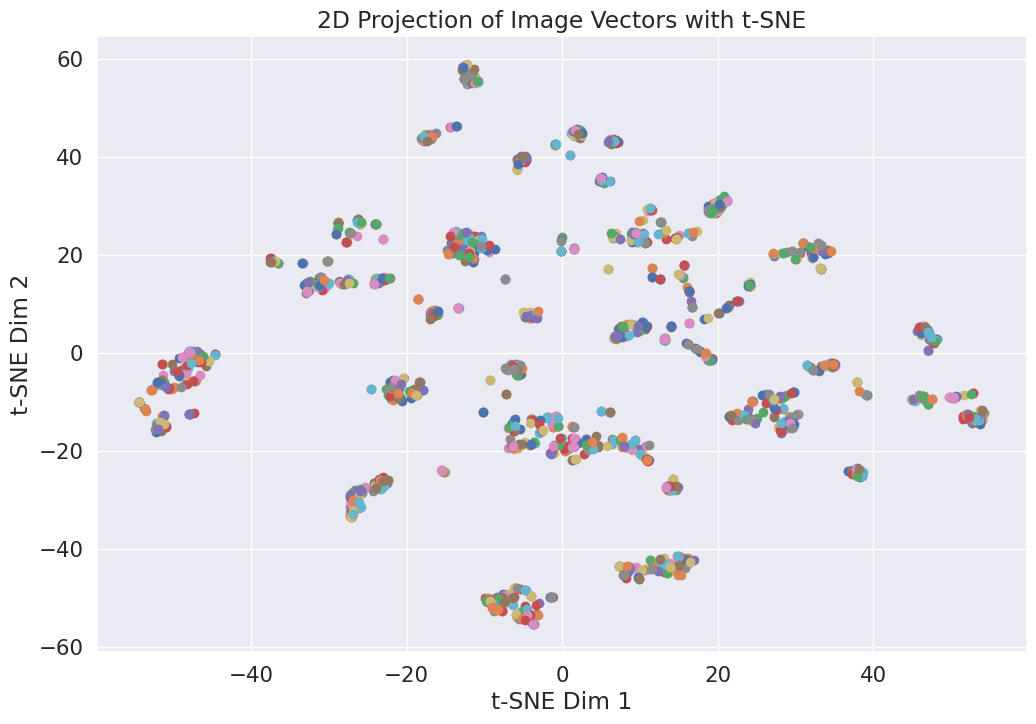

In [322]:
# Standardize the features for better t-SNE results
scaler = StandardScaler()
scaled_vectors = scaler.fit_transform(image_vectors_mat)

pca = PCA(n_components=50)
lowdim_vectors = pca.fit_transform(scaled_vectors)

# Apply t-SNE to reduce dimensions to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(lowdim_vectors)

# umap = UMAP(n_components=2, random_state=42)
# umap_results = umap.fit_transform(scaled_vectors)

# Plot the results
plt.figure(figsize=(12, 8))
for i, txt in enumerate(images):
    plt.scatter(tsne_results[i, 0], tsne_results[i, 1])
    # plt.annotate(txt, (tsne_results[i, 0], tsne_results[i, 1]), fontsize=8)
plt.title("2D Projection of Image Vectors with t-SNE")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()

In [234]:
similarity_matrix = cosine_similarity(image_vectors_mat)

In [211]:
from sklearn.cluster import DBSCAN

In [325]:
dbscan = DBSCAN(eps=0.3, min_samples=4)  # Tune `eps` and `min_samples`
labels = dbscan.fit_predict(image_vectors_mat)

# Organize images by clusters
clusters = {}
for idx, label in enumerate(labels):
    # if label != -1:  # Exclude noise points
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(images[idx])

In [326]:
# clusters

In [327]:
len(clusters)

73

In [329]:
for k, v in clusters.items():
    print(k, len(v))

0 124
1 61
2 10
3 13
4 26
5 76
6 72
7 116
8 24
9 4
10 6
11 35
12 33
13 20
14 24
15 23
16 63
17 50
18 5
-1 176
19 22
20 20
21 43
22 37
57 10
23 64
24 18
25 7
26 20
27 17
28 6
29 5
30 4
69 4
31 4
32 12
54 4
33 10
34 9
35 16
36 9
37 6
38 22
39 7
40 15
41 7
42 5
43 6
44 6
45 40
46 22
47 4
48 6
71 4
49 6
50 8
51 11
52 17
53 6
55 4
63 8
56 4
58 12
59 7
66 7
60 7
61 7
62 4
70 5
64 7
65 4
67 6
68 4


In [331]:
filename2cluster1 = {}
for ind, cluster in clusters.items():
    for filename in cluster:
        filename2cluster1[filename] = ind

In [335]:
df['cluster_dbscan'] = df['Name'].apply(lambda x: filename2cluster1[x])

In [2]:
# save for analyzing the clusters
for ind, cluster in clusters.items():
    # print(ind, len(cluster))
    os.makedirs(f'clusters_2/{ind}', exist_ok=True)
    for img in cluster:
        shutil.copyfile(
            f'train_data_minprirodi/images/{img}',
            f'clusters_2/{ind}/{img}',
        )

In [343]:
df

,Unnamed: 0,Name,Bbox,Class,fname,split,x1,x2,y1,y2,cluster_dbscan,cluster_threshold
0,0,1001958.jpg,"0.7075520833333333,0.5319444444444444,0.282812...",1,train_data_minprirodi/images/1001958.jpg,train,1087,1629,537,995,16,15
1,1,1001958.jpg,"0.09505208333333333,0.6305555555555555,0.19010...",0,train_data_minprirodi/images/1001958.jpg,train,0,365,678,1138,16,15
2,2,1001958.jpg,"0.031510416666666666,0.7434027777777777,0.0630...",0,train_data_minprirodi/images/1001958.jpg,train,0,121,961,1180,16,15
3,3,1002155.jpg,"0.8135416666666667,0.6976851851851852,0.371875...",0,train_data_minprirodi/images/1002155.jpg,train,1205,1919,433,1074,24,27
4,4,1002155.jpg,"0.3221354166666667,0.7939814814814815,0.477604...",0,train_data_minprirodi/images/1002155.jpg,train,160,1077,638,1077,24,27
...,...,...,...,...,...,...,...,...,...,...,...,...
1980,1980,1997546.jpg,"0.34661458333333334,0.490625,0.6015625,0.48958...",1,train_data_minprirodi/images/1997546.jpg,train,88,1243,354,1059,1,1
1981,1981,1997602.jpg,"0.7317708333333334,0.25601851851851853,0.30625...",0,train_data_minprirodi/images/1997602.jpg,val,1111,1699,0,553,2,2
1982,1982,1999067.jpg,"0.5630208333333333,0.5020833333333333,0.519791...",1,train_data_minprirodi/images/1999067.jpg,train,582,1580,355,1091,1,1
1983,1983,1999067.jpg,"0.9572916666666667,0.5881944444444445,0.085416...",0,train_data_minprirodi/images/1999067.jpg,train,1756,1920,440,1254,1,1


### Split data into train and val w.r.t clusters

In [361]:
def get_cluster_val_train_split(df, cluster_col):
    groups = list(df.groupby([cluster_col]))
    groups_sorted = sorted(groups, key=lambda x: len(x[-1]))
    val_set = []
    train_set = []
    for k, gr in groups_sorted:
        # print(k, len(gr))
        if len(val_set) < int(0.2 * len(df)):
            val_set += gr['Name'].to_list()
        else:
            train_set += gr['Name'].to_list()

    train_val_split = []
    for ind, row in df.iterrows():
        if row['Name'] in val_set:
            train_val_split.append('val')
        elif row['Name'] in train_set:
            train_val_split.append('train')
        else:
            raise ValueError("UKNOWN", row['Name'])

    return train_val_split

In [363]:
df['split_dbscan'] = get_cluster_val_train_split(df, 'cluster_dbscan')

In [364]:
for k, gr in df.groupby('split_dbscan'):
    print(k, gr['Class'].value_counts())

train Class
1    967
0    610
Name: count, dtype: int64
val Class
1    227
0    181
Name: count, dtype: int64


In [365]:
df['split_threshold'] = get_cluster_val_train_split(df, 'cluster_threshold')

In [367]:
for k, gr in df.groupby('split_threshold'):
    print(k, gr['Class'].value_counts())

train Class
1    998
0    577
Name: count, dtype: int64
val Class
0    214
1    196
Name: count, dtype: int64


In [368]:
df.to_csv("annotation_split_clusters.csv")